# 6.2.2

In [3]:
import numpy as np
from random import seed
from scipy import signal
import matplotlib.pyplot as plt
from scipy import linalg
import librosa
import librosa.display
import os
import IPython
import sounddevice as sd
from IPython.display import Audio
from scipy.ndimage import convolve

In [157]:
L = 200  # filter length
N = 3500 # synthetic data sequence length
Nexp = 100 # number of experiments to average over
theta = np.random.randn(L) # weights to generate data - optimal convergence for w

# parameters for RLS
beta = 1      # forget factor
lambda_ = 1e-1 # regularization

# parameters for NLMS
mu    = 1.2   # step-size
delta = 1e-3  # regularization

# parameters for the data generation process (data is generated according to the regression model)
# these refer to example 6.1
# y_n = theta^T * x + eta
eta   = 1e-2 # variance for the noise added to y

# reserve memory
MSE_RLS  = np.zeros((N,Nexp))
MSE_NLMS = np.zeros((N,Nexp))

In [158]:
# function doing convolution of matrix, same as convmtx() does in matlab
def convmtx(h,n):
    return linalg.toeplitz(np.hstack([h, np.zeros(n-1)]), np.hstack([h[0], np.zeros(n-1)]))

In [159]:
#%%writefile rls.py
#import numpy as np

def rls(x, y, L, beta, lambda_):
    """ RLS Adaptive filter
    Input
        x: input signal
        y: desired signal
        L: filter length
        beta: forget factor
        lambda_: regularization

    Output
        yhat: filter output
    """

    yhat = np.zeros(np.size(y, 0),)    
    e = np.zeros(np.size(y, 0),)

    X = x.T


    # start RLS
    # initialize        
    w = np.zeros(L,) # theta in the book   
    P = 1/lambda_ * np.eye(L, L)
    
    # for each n do
    for n in range(len(y)):
        # get x_n
        x_n = np.transpose(X[n,:])

        # get filter output
        yhat[n] = np.dot(np.transpose(w), x_n)

        # update iteration
        e[n] = np.subtract(y[n], yhat[n])
        denum = beta + np.dot(np.dot(np.transpose(x_n), P), x_n) # beta + x_n^T * z_n
        K_n = (np.dot(P, x_n))/denum # z_n / (beta + x_n^T * z_n) % this term may be unstable 
        w = w + K_n*e[n]
        
        P = (P - np.dot(np.dot(K_n, np.transpose(x_n)), P))/beta

    mse = np.square(e)
    
    return(yhat, mse)

In [160]:
#%%writefile nlms.py
def nlms(x, y, L, mu, delta):
    """
    Input
        x: input signal
        y: desired signal
        L: filter length
        mu: step size
        delta: small stability value

    Output
        yhat: filter output
    """
    
    # reserve mem
    yhat = np.zeros(np.size(y, 0),)    
    e = np.zeros(np.size(y, 0),)
    
    # if x is a vector we assume x is a time series and we create X accordingly
#     X = convmtx(x, L) #!!! here i didnt put if, but had to change compare to audio exercise
    X = np.transpose(x) 
    
    # start NLMS
    # initialize        
    w = np.zeros(L,) # theta in the book   
    # https://wikimedia.org/api/rest_v1/media/math/render/svg/5a9144713e4baa446220f201d7892010076e6e9e
    # for each n do
    for n in range(len(y)):
        # get x_n
        x_n = X[n,:].T

        # get filter output
        yhat[n] = w.T@x_n

        # update iteration
        e[n] = y[n] - yhat[n]
        # w[n+1] = w[n] + \mu*e[n]*x[n]/(x.T[n]*x[n]) - delta added for stability
        w += ((mu*e[n]/(x_n.T @ x_n + delta)) * x_n)     
              
    mse = np.square(e)
    
    return(yhat, mse)

In [161]:
def lms(x, y, L, mu):
    #  Input
    #      x: input signal
    #      y: desired signal
    #      L: filter length
    #      mu: step size
    # 
    #  Output
    #      yhat: filter output

    # reserve mem
    yhat = np.zeros(np.size(y, 0),)    
    e = np.zeros(np.size(y, 0),)

    # if x is a vector we assume x is a time series and we create X accordingly
    X = convmtx(x, L)
    
    # start LMS
    # initialize        
    w = np.zeros(L,) # theta in the book

    # for each n do
    for n in range(len(y)):
        # get x_n
        x_n = np.transpose(X[n,:])

        # get filter output
        yhat[n] = np.dot(np.transpose(w), x_n)

        # update iteration
        e[n] = np.subtract(y[n], yhat[n])
        w = w + np.dot(np.dot(mu, e[n]), x_n)

    return(yhat)

In [162]:
def lms_rt(x, y, w, mu):
    """
    pass x&y same length as w, mu is scalar learning rate
    """
    yhat = w.T@x
    e = y-yhat
    w += mu*e*x
    
    return (e,yhat)

In [169]:
def nlms_rt(x, y, w, mu, delta):
    yhat = w.T@x
    e = y - yhat
    w += ((mu*e)/(x.T@x+delta))*x
    #print((x.T@x).shape)
    return (e,yhat)

## Generate data and run a bunch of experiments

In [170]:
# iterate experiments
for i in range(Nexp):
    # generate normalized input
    x = np.random.randn(N+L-1)
    x /= np.std(x, ddof=0);    

    # put time signal on matrix form
    X = convmtx(x,L).T
    X = X[:,L-1:]

    # create output
    noise = np.sqrt(eta)*np.random.randn(N)
    y = X[:,:N].T@theta + noise
    
    w = np.zeros(L)
    for j in range(L,N):
        # run RLS and NLMS
        #_,  MSE_RLS[j, i] = rls(X,y,L,1,lambda_)
        _, MSE_NLMS[j, i] = nlms_rt(X[:,j],y[j-L:j], w, mu, delta)

/home/zach/anaconda3_v2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/home/zach/anaconda3_v2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


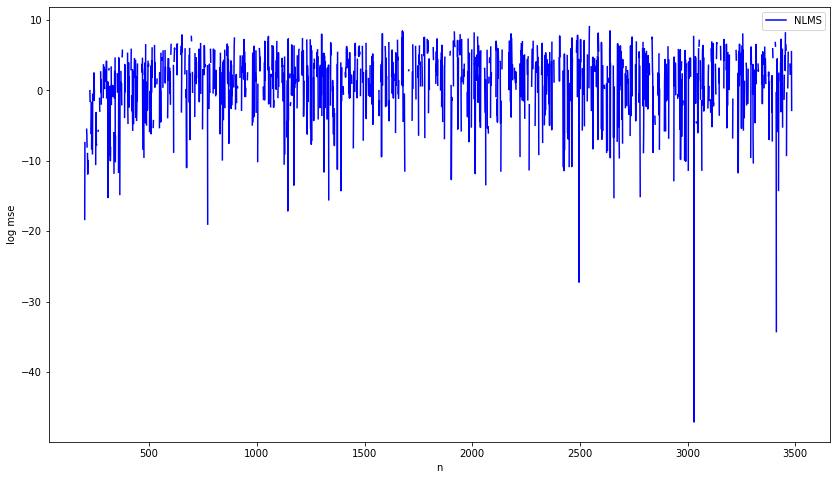

In [171]:
# plot
MSEav_rls = np.sum(MSE_RLS, axis=1)/Nexp 
MSEav_nlms = np.sum(MSE_NLMS, axis=1)/Nexp

plt.figure(figsize=(14, 8))
plt.plot(10*np.log10(MSEav_nlms), color = 'b', label='NLMS')
#plt.plot(10*np.log10(MSEav_rls), color = 'orange', label='RLS')
plt.legend(loc='upper right')
plt.xlabel('n')
plt.ylabel('log mse')
plt.show()

# 6.3.2

In [1]:
L = 5  # Dimension of the unknown vector
N = 1000 # Number of Data
Nexp = 200 # number of experiments
theta = np.random.normal(size = L)

# parameters for NLMS
mu    = 0.5   # step-size
delta = 1e-3  # regularization

# parameters for RLS
beta = 0.9      # forget factor
lambda_ = 1e-3  # regularization

# parameters for the data generation process
# these refer to eq (6.61)
alpha = 0.97 # autoregressive coefficient for theta changes
omega = 1e-2 # variance for the noise added to theta
eta   = 1e-3 # variance for the noise added to y

# reserve memory
MSE_RLS  = np.zeros((N,Nexp))
MSE_NLMS = np.zeros((N,Nexp))
theta = np.zeros((L,N)) # Unknown parameter

NameError: name 'np' is not defined

In [173]:
# iterate experiments
for i in range(Nexp):
    # draw thetas
    theta=np.zeros((L,N)) 
    theta[:,0]=np.random.randn(L)
    
    # Generate the time varying channel
    for ii in range(1, N): 
        theta[:,ii] = alpha * theta[:,ii-1] + np.sqrt(omega) * np.random.normal(size=L)
        
    # generate the X and y's
    X = np.random.randn(L,N)
    noise = np.random.randn(N) * np.sqrt(eta)
    y = np.zeros(N,)
    
    for ii in range(N):
        y[ii] = np.dot(np.transpose(X[:,ii]), theta[:,ii])
    
    y = y + noise

    # run RLS and NLMS
    _, MSE_RLS[:, i] = rls(X,y,L,beta,lambda_)
    _, MSE_NLMS[:, i] = nlms(X,y,L,mu,delta)

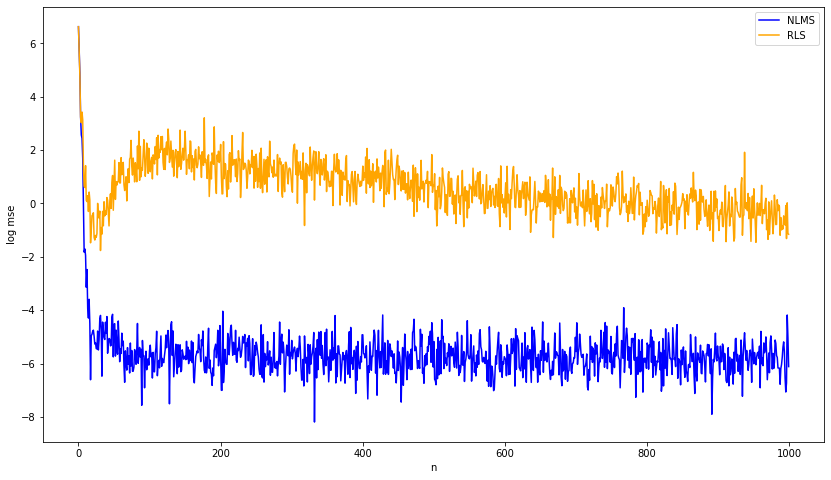

In [174]:
MSEav_rls = np.sum(MSE_RLS, axis=1)/Nexp 
MSEav_nlms = np.sum(MSE_NLMS, axis=1)/Nexp

plt.figure(figsize=(14, 8))
plt.plot(10*np.log10(MSEav_nlms), color = 'b', label='NLMS')
plt.plot(10*np.log10(MSEav_rls), color = 'orange', label='RLS')
plt.legend(loc='upper right')
plt.xlabel('n')
plt.ylabel('log mse')
plt.show()

# 6.4.1

In [175]:
n, Fs = librosa.load('data/highwaynoise.wav', sr = 16000) # the highway noise
x, Fs = librosa.load('data/noisy_speech.wav', sr = 16000) # noisy speech is x

FileNotFoundError: [Errno 2] No such file or directory: 'data/highwaynoise.wav'

In [ ]:
# Play highway noise
IPython.display.Audio('data/highwaynoise.wav')

In [88]:
# Play noisy speech
IPython.display.Audio('data/noisy_speech.wav')

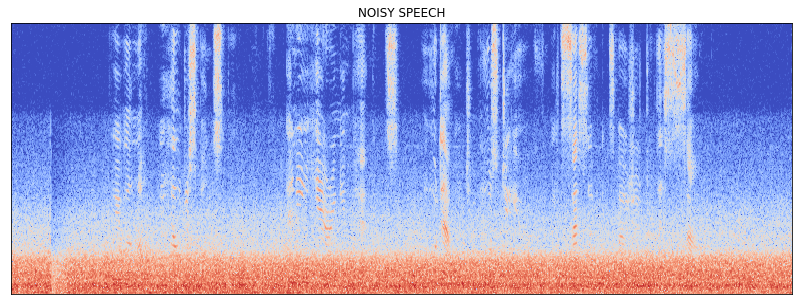

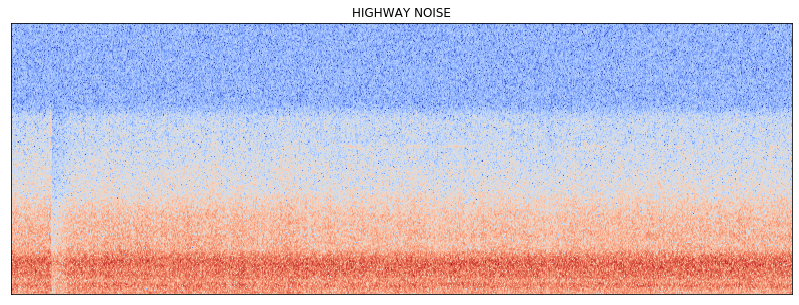

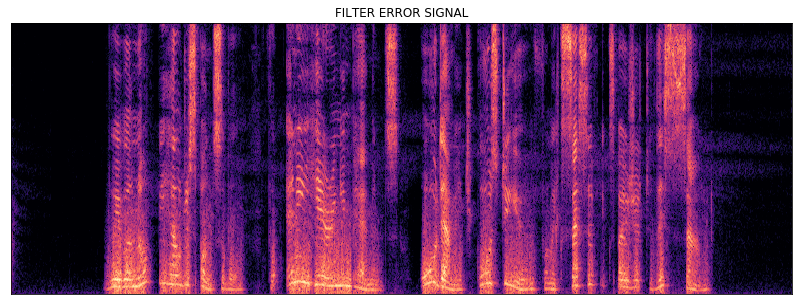

In [102]:
# one of lms, nlms, rls
adaptive_algo = 'lms'

# Filter Length
L = 30

# parameters for lms 
mu_lms = 0.5   # step size

# parameters for nlms
mu_nlms = 0.5  # normalized step-size
delta = 1e-2   # regularization parameter

# parameters for rls
beta = 0.997   # forget factor
lambda_ = 1e2   # regularization

# Switch between adaptive algorithms
if adaptive_algo == 'lms':
    y = lms(n, x, L, mu_lms)
elif adaptive_algo == 'nlms':
    y, _ = nlms(n, x, L, mu_nlms, delta)
elif adaptive_algo == 'rls':
    y, _ = rls(n, x, L, beta, lambda_)


# Plot the spectrograms of the filtered signals
# speech
spec_x = librosa.stft(x, n_fft=512, hop_length=32, center=True)
x_db = librosa.amplitude_to_db(abs(spec_x))
plt.figure(figsize=(14, 5))
plt.title("NOISY SPEECH")
librosa.display.specshow(x_db, sr=Fs)

# noisy speech
spec_n = librosa.stft(n, n_fft=512, hop_length=32, center=True)
n_db = librosa.amplitude_to_db(abs(spec_n))
plt.figure(figsize=(14, 5))
plt.title("HIGHWAY NOISE")
librosa.display.specshow(n_db, sr=Fs)

# LMS filter output
spec_y = librosa.stft(x-y, n_fft=512, hop_length=32, center=True)
y_db = librosa.amplitude_to_db(abs(spec_y))
plt.figure(figsize=(14, 5))
plt.title("FILTER ERROR SIGNAL")
librosa.display.specshow(y_db, sr=Fs)

In [92]:
# Play the result
print('Play error signal = enhanced speech')
Audio(x-y, Fs)

Play error signal = enhanced speech


NameError: name 'Audio' is not defined

In [ ]:
# read original speech without noise
o, Fs = librosa.load('data/voice.wav', sr = 16000) 

# Play original speech without noise
IPython.display.Audio('data/voice.wav')

In [ ]:
def mse(xhat, x):
    a = np.dot(x, xhat) / np.dot(xhat, xhat)
    e = np.mean(np.square(np.subtract(x, a*xhat)))
    return e

# Compute MSE, by comparing original speech to output from algorithm, so enhanced speech
e = mse(x-y, o);
print('Mean squared error: ', e)

# 6.4.2

In [ ]:
n, Fs = librosa.load('data/ambulance.wav', sr = 22050)
x, Fs = librosa.load('data/ambulance_speech.wav', sr = 22050)

In [ ]:
# Play ambulance noise
IPython.display.Audio('data/ambulance.wav')

In [ ]:
# Play ambulance speech
IPython.display.Audio('data/ambulance_speech.wav')

In [ ]:
# one of lms, nlms, rls
adaptive_algo = 'lms'

# Filter Length
L = 30

# parameters for lms 
mu_lms  = 0.2   # step size

# parameters for nlms
mu_nlms = 0.05  # normalized step-size
delta   = 1e-2   # regularization parameter

# parameters for rls
beta    = 0.997   # forget factor
lambda_ = 1e5   # regularization

# Switch between adaptive algorithms
if adaptive_algo == 'lms':
    y = lms(n, x, L, mu_lms)
elif adaptive_algo == 'nlms':
    y, _ = nlms(n, x, L, mu_nlms, delta)
elif adaptive_algo == 'rls':
    y, _ = rls(n, x, L, beta, lambda_)


# Plot the spectrograms of the filtered signals
# speech
spec_x = librosa.stft(x, n_fft=512, hop_length=32, center=True)
x_db = librosa.amplitude_to_db(abs(spec_x))
plt.figure(figsize=(14, 5))
plt.title("NOISY SPEECH")
librosa.display.specshow(x_db, sr=Fs)

# noisy speech
spec_n = librosa.stft(n, n_fft=512, hop_length=32, center=True)
n_db = librosa.amplitude_to_db(abs(spec_n))
plt.figure(figsize=(14, 5))
plt.title("AMBULANCE NOISE")
librosa.display.specshow(n_db, sr=Fs)

# LMS filter output
spec_y = librosa.stft(x-y, n_fft=512, hop_length=32, center=True)
y_db = librosa.amplitude_to_db(abs(spec_y))
plt.figure(figsize=(14, 5))
plt.title("FILTER ERROR SIGNAL")
librosa.display.specshow(y_db, sr=Fs)
# # ----------------------------------------------------------------

In [95]:
# Play the result
print('Play error signal = enhanced speech')
Audio(x-y, rate=Fs)

Play error signal = enhanced speech


In [97]:
Audio(y, rate=Fs)

In [98]:
# read original speech without noise
o, Fs = librosa.load('data/kennedy.wav', sr = 22050) 

# Play original speech without noise
IPython.display.Audio('data/kennedy.wav')

In [99]:
# calculating the (optimally scaled) mean squared error MSE
# between a signal estimate and an original (noise free) signal
def mse(xhat, x):
    a = np.dot(x, xhat) / np.dot(xhat, xhat)
    e = np.mean(np.square(np.subtract(x, a*xhat)))
    return e

# Compute MSE, by comparing original speech to output from algorithm, so enhanced speech
e = mse(x-y, o);
print('Mean squared error: ', e)

ValueError: shapes (326545,) and (169531,) not aligned: 326545 (dim 0) != 169531 (dim 0)